
# AIC-103 Data Science - Module 3
## Incident Data Analysis & Word Cloud Generation

---

## Table of Contents
1. [Introduction](#1-introduction)
2. [Setup and Data Loading](#2-setup-and-data-loading)
3. [Initial Exploration](#3-initial-exploration)
4. [Data Cleaning](#4-data-cleaning)
5. [Word Cloud Generation](#5-word-cloud-generation)
6. [Optional Additional Exploration](#6-optional-additional-exploration)
7. [Conclusion](#7-conclusion)

## 1. Introduction

In this notebook, we analyze the **Incident Elevator Dataset** (`incident.json`) to:

-   Explore the data structure and missing values.
-   Clean the text in the `"Reported occurrence narrative"` column by removing stop words, punctuation, and applying lemmatization.
-   Generate a **word cloud** to visually identify frequent terms in the incidents.
-   We will also perform basic data checks and prepare an output suitable for including in our final report and presentation.

## 2. Setup and Data Loading

In [51]:
import pandas as pd


import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

# Ensure that stopwords or wordnet are installed:
# nltk.download('stopwords')
# nltk.download('wordnet')


In [52]:
# 1. Load the Incident Data
try:
    df_incident = pd.read_json('../data/raw/incident.json')
    print(f"Incident Data Loaded. Shape: {df_incident.shape}")
except FileNotFoundError as e:
    print("Error: 'incident.json' not found. Check your file path.")
    raise e

Incident Data Loaded. Shape: (2446, 46)


## 3. Initial Exploration


In [53]:
# Quick look at the first few rows
df_incident.head()


,Incident Number,Creation Date,Fatal Injury Victim,Concussion Intracranial Inju,Burns Severe,Burns Minor,Whiplash,Spinal Injury,Amputation,Injury Leading Deafness,...,No Injury,elevating devices number,Specific Root Cause,Reported occurrence narrative,Time of Occurrence,Summarized detail of Inspection and tests,Inspector's Conclusion,Incident Summary,Task Number,release
0,518574,14-Jan-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22202,None,Elevator-Flood on 13th floor ran down the stai...,2:00:00 PM,None,None,ED-Near Miss,3200103,yes
1,518582,14-Jan-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22203,None,Elevator-Flood on 13th floor ran down stairs a...,2:00:00 PM,None,None,ED-Near Miss,3200141,yes
2,519464,17-Jan-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,87727,None,Elevator-Man with dog tried to kick dog leash ...,12:00:00 AM,None,None,ED-Incident,3202552,yes
3,524274,27-Jan-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,17594,None,Elevator - a piece of trim fell on person in e...,12:00:00 AM,None,None,ED-Incident,3212548,yes
4,519720,18-Jan-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,81630,None,Elevator-Elderly man exiting elevator got hit ...,7:30:00 PM,None,None,ED-Incident,3203135,yes


In [54]:
# Check for missing values
print("\nMissing values:")
display(df_incident.isnull().sum())


Missing values:


Incident Number                                 0
Creation Date                                   0
Fatal Injury Victim                          1384
Concussion Intracranial Inju                 1384
Burns Severe                                 1384
Burns Minor                                  1384
Whiplash                                     1384
Spinal Injury                                1384
Amputation                                   1384
Injury Leading Deafness                      1384
Heart Attack                                 1384
Fracture Major Bone                          1384
Eye Injury                                   1384
Electric Shock Severe                        1384
Electric Shock Minor                         1384
Dislocation Limb                             1384
Bruise Hemorrhage Interna                    1384
Exposure Carcinomatou Poison                 1384
Swelling                                     1384
Sprained Twisted Joints Muscle               1384


In [55]:
# Basic info
print("\nDataFrame info:")
df_incident.info()



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2446 entries, 0 to 2445
Data columns (total 46 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Incident Number                            2446 non-null   int64  
 1   Creation Date                              2446 non-null   object 
 2   Fatal Injury Victim                        1062 non-null   float64
 3   Concussion Intracranial Inju               1062 non-null   float64
 4   Burns Severe                               1062 non-null   float64
 5   Burns Minor                                1062 non-null   float64
 6   Whiplash                                   1062 non-null   float64
 7   Spinal Injury                              1062 non-null   float64
 8   Amputation                                 1062 non-null   float64
 9   Injury Leading Deafness                    1062 non-null   float64
 10  Heart A

**Observations**

-   We see many missing values (`NaN`) across various injury-related columns.
-   Most crucial for us is `"Reported occurrence narrative"`. If it’s missing, we will fill it with an empty string before cleaning.

## 4. Data Cleaning


### 4.1. Fill Missing Narratives


In [56]:
# Fill missing values in the "Reported occurrence narrative" with empty strings
df_incident['Reported occurrence narrative'] = (
    df_incident['Reported occurrence narrative'].fillna('')
)

### 4.2. Text Cleaning Functions
We’ll remove punctuation, convert to lowercase, remove stop words, and apply lemmatization.

In [57]:
# Prepare NLTK objects
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [58]:
def clean_text(text):
    """
    Convert text to lowercase, remove punctuation, split into tokens,
    remove stopwords, and lemmatize each token.
    """
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [59]:
# Apply cleaning to create a new column
df_incident['cleaned_text'] = df_incident['Reported occurrence narrative'].apply(clean_text)

### 4.3. Quick Verification


In [60]:
# Inspect a few rows to confirm the 'cleaned_text' looks correct
df_incident[['Reported occurrence narrative', 'cleaned_text']].head(5)

,Reported occurrence narrative,cleaned_text
0,Elevator-Flood on 13th floor ran down the stai...,elevatorflood 13th floor ran stair elevator
1,Elevator-Flood on 13th floor ran down stairs a...,elevatorflood 13th floor ran stair elevator in...
2,Elevator-Man with dog tried to kick dog leash ...,elevatorman dog tried kick dog leash elevator ...
3,Elevator - a piece of trim fell on person in e...,elevator piece trim fell person elevator sore ...
4,Elevator-Elderly man exiting elevator got hit ...,elevatorelderly man exiting elevator got hit d...


## 5. Word Cloud Generation
#### The **word cloud** helps us see the most common words in the incident narratives at a glance.

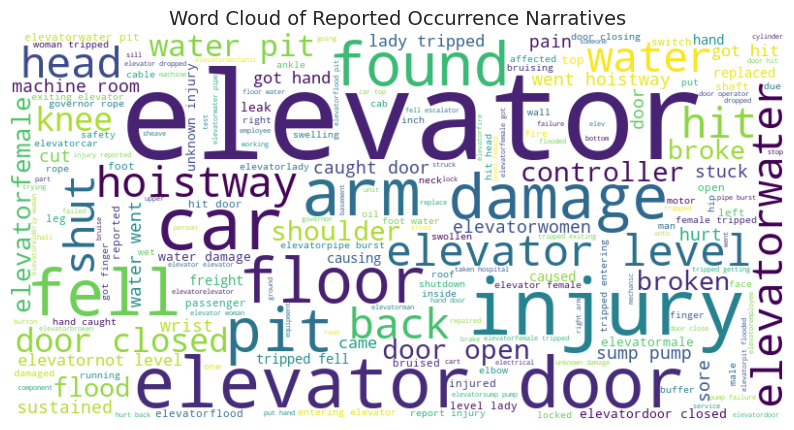

In [61]:
# Now, let's combine all the cleaned text into one big string!
all_text = " ".join(df_incident['cleaned_text'].tolist())

# Then, we can create the word cloud...
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'
).generate(all_text)

# And finally, let's see how it looks
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Reported Occurrence Narratives", fontsize=14)
plt.show()


In [62]:
# It looks good for now, so we can save it in our reports dir
wordcloud.to_file('../reports/figures/incident_wordcloud.png')


In [63]:
from collections import Counter

# Tokenize the cleaned_text column
all_tokens = " ".join(df_incident['cleaned_text']).split()
token_counts = Counter(all_tokens)

# Show the top 10 words
print("Top 10 frequent words in 'cleaned_text':")
print(token_counts.most_common(10))

Top 10 frequent words in 'cleaned_text':
[('elevator', 1233), ('door', 664), ('water', 417), ('pit', 317), ('injury', 290), ('tripped', 265), ('hit', 248), ('fell', 247), ('floor', 239), ('got', 234)]


## 7. Conclusion

In this notebook, we have:

-   **Loaded** the `incident.json` dataset.
-   **Explored** and addressed missing data in the `"Reported occurrence narrative"` column.
-   **Cleaned** the text via removing punctuation, stop words, and lemmatizing.
-   **Generated** a **word cloud** to visualize the most common terms.

These steps fulfill the core **AIC-103** requirement to create a **word cloud** from incident narratives.